# Cloud Masks

The products contain several raster and vector files that represent cloud masks or cloud propabilities.

This notebook explores the contents of these files and evaluates how a helper for dealing with cloud masks can be implemented.

""


In [1]:
import geopandas as gpd
from rasterio.features import geometry_window

tempelhofer_feld = gpd.read_file('resources/tempelhofer_feld/tempelhofer_feld.geojson')

In [2]:
from sentinel_helpers import scihub_band_paths, raster_cloud_mask
product_path = 'resources/tempelhofer_feld/S2A_MSIL2A_20190114T101351_N0211_R022_T32UQD_20190114T113404.zip'

In [6]:
data, transform = raster_cloud_mask(product_path)

In [7]:
data.shape

(1, 10980, 10980)

In [15]:
raster_cloud_mask = scihub_band_paths(product_path, ['MSK_CLDPRB'], '20m')[0]
raster_cloud_mask

PosixPath('zip+file:/home/jovyan/sources/resources/tempelhofer_feld/S2A_MSIL2A_20190114T101351_N0211_R022_T32UQD_20190114T113404.zip!/S2A_MSIL2A_20190114T101351_N0211_R022_T32UQD_20190114T113404.SAFE/GRANULE/L2A_T32UQD_A018609_20190114T101352/QI_DATA/MSK_CLDPRB_20m.jp2')

In [10]:
from rasterio.windows import Window

In [16]:
import rasterio as r
import rasterio.plot as rplt

In [19]:
with r.open(raster_cloud_mask) as mask:
    window = geometry_window(mask, tempelhofer_feld.to_crs(mask.crs)['geometry'])
window

Window(col_off=4893, row_off=3806, width=119, height=99)

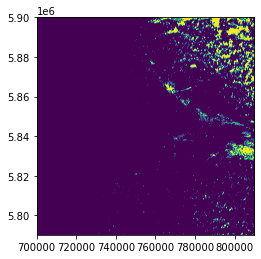

In [4]:
with r.open(raster_cloud_mask) as mask:
    rplt.show(mask.read() > 64, transform=mask.transform)

We can find out the vector cloud mask path by manipulating the path to the raster cloud mask:

In [5]:
vector_cloud_mask = raster_cloud_mask.replace(raster_cloud_mask.split('/')[-1], 'MSK_CLOUDS_B00.gml')
vector_cloud_mask

'zip+file://input/tempelhofer_feld/S2A_MSIL2A_20190114T101351_N0211_R022_T32UQD_20190114T113404.zip!/S2A_MSIL2A_20190114T101351_N0211_R022_T32UQD_20190114T113404.SAFE/GRANULE/L2A_T32UQD_A018609_20190114T101352/QI_DATA/MSK_CLOUDS_B00.gml'

## Trying to read the cloud mask from the zip file

In [6]:
import geopandas as gpd

Fiona needs very long to open the GML file, the following lines are commented out because they did not terminate in an acceptable time (< 5min):

In [7]:
#with fiona.open(vector_cloud_mask) as f:
#    pass

In [8]:
# gpd.read_file(vector_cloud_mask)

The workaround is to unpack the vector file before opening it:

In [9]:
import fiona
from pathlib import Path
from shapely.geometry import shape
from shapely.ops import unary_union
from tempfile import TemporaryDirectory
from zipfile import ZipFile

tmp_path = vector_cloud_mask.replace('zip+file://', '')
zip_path, file_path = tmp_path.split('!/')

with TemporaryDirectory() as tmp_dir, ZipFile(zip_path) as f:
    f.extract(file_path, tmp_dir)
    tmp_path = Path(tmp_dir) / file_path
    
    # read with geopandas
    cloud_mask_geopandas = gpd.read_file(tmp_path)['geometry'].unary_union
    
    # skip geopandas and read with fiona; this generates a RuntimeWarning
    # about performance
    with fiona.open(tmp_path) as features:
        cloud_mask_fiona = unary_union([shape(f['geometry']) for f in features])

/opt/conda/lib/python3.8/site-packages/geopandas/geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
<ipython-input-9-ee0abf1a292b>:21: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  cloud_mask_fiona = unary_union([shape(f['geometry']) for f in features])


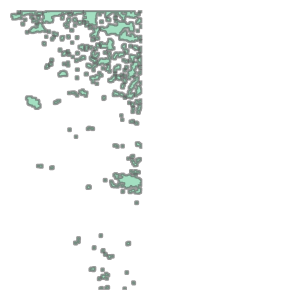

In [10]:
cloud_mask_geopandas

We can skip `geopandas`geopandas and use `fiona` directly:

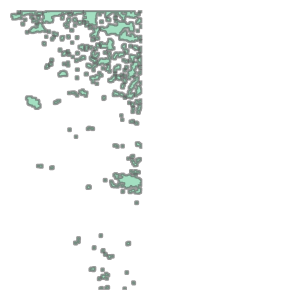

In [11]:
cloud_mask_fiona

Note that the aspect ratio is different than the raster file plotted above.

## Using the helper function

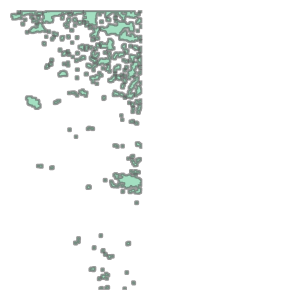

In [12]:
from sentinel_helpers import scihub_cloud_mask
scihub_cloud_mask(product_path)